## Importação dos arquivos e geração dos segmentos

In [1]:
import os
import pandas as pd
import numpy as np
import pprint

# =============================================================================
# BLOCO 1: CONFIGURAÇÃO, CARREGAMENTO, DIVISÃO (80/20) E SEGMENTAÇÃO (CORRIGIDO)
# =============================================================================

# --- 1. CONFIGURAÇÕES GERAIS ---
caminho_raiz = r'C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset' # IMPORTANTE: Verifique se este caminho está correto
params_drive_end = {'n': 9, 'd': 0.3126, 'D': 1.537, 'phi_graus': 0.0}
TAXA_AMOSTRAL = 12000

# Dicionários de mapeamento
mapa_tipo_falha = {'IR': 'Pista Interna', 'B': 'Esfera', 'OR': 'Pista Externa', 'Normal': 'Normal'}
mapa_diametro_falha = {'7': '0.007"', '14': '0.014"', '21': '0.021"'}

# --- PARÂMETROS DE SEGMENTAÇÃO ---
tamanho_segmento = 4096
sobreposicao_percentual = 0.3
passo = int(tamanho_segmento * (1 - sobreposicao_percentual))

# --- 2. CARREGAMENTO, DIVISÃO E PROCESSAMENTO ---
dicionario_treino = {} # Dicionário para 80% dos dados normais
dicionario_teste = {} # Dicionário para 20% normais + 100% falhas reais

print(f"Iniciando a leitura e segmentação dos arquivos em '{caminho_raiz}'...")
print("Dados normais serão divididos (80% treino / 20% teste).")
print("Dados de falha real irão 100% para o teste.")

# Função auxiliar para segmentar um sinal e adicionar ao dicionário
def segmentar_e_adicionar(sinal, metadados, dicionario_alvo, chave_base):
    # Verifica se o sinal é longo o suficiente para pelo menos um segmento
    if len(sinal) < tamanho_segmento:
        # print(f"Aviso: Sinal da base '{chave_base}' muito curto ({len(sinal)} amostras) para gerar segmentos. Ignorando.")
        return 0

    num_segmentos_criados = 0
    for i, inicio in enumerate(range(0, len(sinal) - tamanho_segmento + 1, passo)):
        segmento = sinal[inicio : inicio + tamanho_segmento]
        df_segmento = pd.DataFrame({'amplitude': segmento})

        # Adiciona metadados
        df_segmento['arquivo_origem'] = metadados['nome_arquivo']
        df_segmento['rotacao_rpm'] = metadados['rpm']
        df_segmento['tipo_falha'] = metadados['tipo_falha']
        df_segmento['diametro_falha'] = metadados['diametro_falha']
        df_segmento['local_sensor'] = 'Drive End'

        chave_segmento = f"{chave_base}_seg_{i}"
        dicionario_alvo[chave_segmento] = df_segmento
        num_segmentos_criados += 1
    return num_segmentos_criados

# Loop principal pelos arquivos
for pasta_atual, _, arquivos in os.walk(caminho_raiz):
    for nome_arquivo in arquivos:
        # Processar apenas arquivos .npz
        if nome_arquivo.endswith('.npz'):
            caminho_completo = os.path.join(pasta_atual, nome_arquivo)

            # Decodificação de metadados
            nome_sem_ext = nome_arquivo.replace('.npz', '')
            partes = nome_sem_ext.split('_')
            rpm_str = partes[0]
            is_normal = 'Normal' in nome_arquivo

            metadados = {
                'nome_arquivo': nome_arquivo,
                'rpm': int(rpm_str) if rpm_str.isdigit() else 0,
                'tipo_falha': 'Normal' if is_normal else mapa_tipo_falha.get(partes[1].split('@')[0], 'Desconhecido'),
                'diametro_falha': 'N/A' if is_normal else mapa_diametro_falha.get(partes[2], 'Desconhecido')
            }

            try:
                dados_npz = np.load(caminho_completo)
                sensor_cod = 'DE' # Foco apenas no Drive End, como no seu código original

                if sensor_cod in dados_npz.files:
                    sinal_completo = dados_npz[sensor_cod].ravel()

                    if is_normal:
                        # DIVIDE O SINAL NORMAL EM 80/20
                        ponto_corte = int(len(sinal_completo) * 0.8)
                        sinal_treino = sinal_completo[:ponto_corte]
                        sinal_teste = sinal_completo[ponto_corte:]

                        chave_base_normal = f"{nome_sem_ext}_{sensor_cod}"
                        segmentar_e_adicionar(sinal_treino, metadados, dicionario_treino, f"{chave_base_normal}_treino")
                        segmentar_e_adicionar(sinal_teste, metadados, dicionario_teste, f"{chave_base_normal}_teste")

                    else:
                        # Sinais com falha (REAIS) vão inteiramente para o TESTE
                        # Lógica de chave para arquivos de falha (igual ao seu original)
                        partes_chave = nome_sem_ext.split('_')
                        partes_chave[-1] = partes_chave[-1].rstrip('0123456789')
                        chave_base_falha = "_".join(partes_chave)
                        
                        # =================================================================
                        # MUDANÇA PRINCIPAL AQUI: Envia falhas reais para o dicionario_teste
                        # =================================================================
                        segmentar_e_adicionar(sinal_completo, metadados, dicionario_teste, chave_base_falha)

            except Exception as e:
                print(f"Erro ao processar o arquivo {nome_arquivo}: {e}")

# --- Relatório Final (Atualizado para refletir a nova lógica) ---
print("\n--- Processo Concluído! ---")
print(f"Total de segmentos de TREINO (APENAS 80% normais): {len(dicionario_treino)}")
print(f"Total de segmentos de TESTE (falhas reais + 20% normais): {len(dicionario_teste)}")

if not dicionario_teste:
    print("\nAVISO: O dicionário de teste está vazio. Verifique se os arquivos 'Normal' existem e se os sinais são longos o suficiente.")

if dicionario_treino:
    # Garante que dicionário não está vazio antes de tentar acessar
    if len(dicionario_treino) > 0:
        chave_exemplo_treino = list(dicionario_treino.keys())[0]
        print(f"\nExemplo de um segmento de TREINO (chave: '{chave_exemplo_treino}'):")
        print(dicionario_treino[chave_exemplo_treino].head())
    else:
        print("\nO dicionário de TREINO está vazio.")

if dicionario_teste:
     # Garante que dicionário não está vazio antes de tentar acessar
    if len(dicionario_teste) > 0:
        chave_exemplo_teste = list(dicionario_teste.keys())[0]
        print(f"\nExemplo de um segmento de TESTE (chave: '{chave_exemplo_teste}'):")
        print(dicionario_teste[chave_exemplo_teste].head())
    else:
        print("\nO dicionário de TESTE está vazio.")

Iniciando a leitura e segmentação dos arquivos em 'C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset'...
Dados normais serão divididos (80% treino / 20% teste).
Dados de falha real irão 100% para o teste.

--- Processo Concluído! ---
Total de segmentos de TREINO (APENAS 80% normais): 470
Total de segmentos de TESTE (falhas reais + 20% normais): 2897

Exemplo de um segmento de TREINO (chave: '1730_Normal_DE_treino_seg_0'):
   amplitude   arquivo_origem  rotacao_rpm tipo_falha diametro_falha  \
0   0.014603  1730_Normal.npz         1730     Normal            N/A   
1   0.054449  1730_Normal.npz         1730     Normal            N/A   
2   0.107646  1730_Normal.npz         1730     Normal            N/A   
3   0.133722  1730_Normal.npz         1730     Normal            N/A   
4   0.112652  1730_Normal.npz         1730     Normal            N/A   

  local_sensor  
0    Drive End  
1    Drive End  
2    Drive End  
3    Drive End  
4    Drive End  

Exemplo de um segmento de TESTE 

## Criação do sinal sintético de falha 

In [ ]:
# =============================================================================
# BLOCO 2: FUNÇÃO DE GERAÇÃO DE DADOS SINTÉTICOS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def gerar_sinais_sinteticos(segmentos_normais_treino, 
                            TAXA_AMOSTRAL, params_drive_end,
                            amplitudes_referencia, multiplicadores, fases_para_adicionar_rad,
                            # --- Parâmetros do Experimento ---
                            freq_natural_hz, 
                            damping_ratio,
                            profundidade_modulacao,
                            duracao_pulso_seg):
    """
    Gera o DataFrame de sinais sintéticos com base nos parâmetros de simulação.
    """
    
    print(f"Iniciando Geração de Sinais (Freq: {freq_natural_hz} Hz, Damping: {damping_ratio}, Mod: {profundidade_modulacao})")
    
    # --- Função Interna para criar a Resposta ao Impulso ---
    def criar_resposta_impulso(taxa_amostral, freq_natural, damping, duracao_pulso):
        n_pontos_pulso = int(duracao_pulso * taxa_amostral)
        t_pulse = np.linspace(0, duracao_pulso, n_pontos_pulso, endpoint=False)
        A = damping * 2 * np.pi * freq_natural
        omega_d = 2 * np.pi * freq_natural * np.sqrt(1 - damping**2)
        pulso = np.exp(-A * t_pulse) * np.sin(omega_d * t_pulse)
        return pulso
    
    # --- 4. GERAÇÃO E COMBINAÇÃO DOS SINAIS ---
    lista_sinais_treino = []
    
    # Cria o pulso de resposta UMA VEZ
    resposta_impulso_unitaria = criar_resposta_impulso(TAXA_AMOSTRAL, freq_natural_hz, damping_ratio, duracao_pulso_seg)
    if np.max(np.abs(resposta_impulso_unitaria)) > 0:
        resposta_impulso_unitaria /= np.max(np.abs(resposta_impulso_unitaria)) # Normaliza

    # Loop para gerar os sinais com falha sintética
    for chave_normal, df_normal in segmentos_normais_treino.items():
        sinal_normal_base = df_normal['amplitude'].values
        rpm_atual = df_normal['rotacao_rpm'].iloc[0]
        
        N_PONTOS = len(sinal_normal_base)
        duracao_s = N_PONTOS / TAXA_AMOSTRAL
        t = np.linspace(0.0, duracao_s, N_PONTOS, endpoint=False)
        
        fr_hz = rpm_atual / 60
        freqs_teoricas = calcular_frequencias_rolamento(fr=fr_hz, **params_drive_end)
        
        for tipo_falha_sintetica in ['Pista Externa', 'Pista Interna', 'Esfera']:
            freq_teorica = freqs_teoricas[tipo_falha_sintetica] 
            amp_ref = amplitudes_referencia['Drive End'][tipo_falha_sintetica]
            
            # 1. Crie o TREM DE IMPULSOS
            trem_de_impulsos = np.zeros(N_PONTOS)
            periodo_falha_seg = 1.0 / freq_teorica
            ts_segundos = 1.0 / TAXA_AMOSTRAL 
            for t_impacto in np.arange(0, duracao_s, periodo_falha_seg):
                idx = int(t_impacto / ts_segundos)
                if idx < N_PONTOS:
                    trem_de_impulsos[idx] = 1.0
            
            # 2. Gere o sinal de "RINGING"
            sinal_falha_ringing = np.convolve(trem_de_impulsos, resposta_impulso_unitaria, mode='same')
            
            # 3. Aplique a MODULAÇÃO DE AMPLITUDE (AM) específica da falha
            if tipo_falha_sintetica == 'Pista Externa':
                sinal_falha_bruto = sinal_falha_ringing
            elif tipo_falha_sintetica == 'Pista Interna':
                modulador_fr = (1 + profundidade_modulacao * np.sin(2 * np.pi * fr_hz * t))
                sinal_falha_bruto = sinal_falha_ringing * modulador_fr
            elif tipo_falha_sintetica == 'Esfera':
                freq_ftf = freqs_teoricas['FTF']
                modulador_ftf = (1 + profundidade_modulacao * np.sin(2 * np.pi * freq_ftf * t))
                sinal_falha_bruto = sinal_falha_ringing * modulador_ftf
            
            # Loop de multiplicadores e fases
            for mult in multiplicadores:
                for fase in fases_para_adicionar_rad:
                    amplitude_final = amp_ref * mult
                    deslocamento_idx = int((fase / (2 * np.pi)) * periodo_falha_seg / ts_segundos)
                    sinal_falha_sintetico = np.roll(sinal_falha_bruto, deslocamento_idx) * amplitude_final
                    sinal_final_combinado = sinal_normal_base + sinal_falha_sintetico
                    
                    lista_sinais_treino.append({
                        'sinal_final': sinal_final_combinado,
                        'tipo_falha_adicionada': tipo_falha_sintetica,
                        'rpm': rpm_atual,
                        'multiplicador_amplitude': mult,
                        'fase_adicionada_rad': fase,
                        'base_normal': chave_normal
                    })

    # --- 5. ADIÇÃO DOS SEGMENTOS NORMAIS ORIGINAIS DE TREINO ---
    print(f"Adicionando {len(segmentos_normais_treino)} segmentos normais de TREINO...")
    for chave_normal, df_normal in segmentos_normais_treino.items():
        lista_sinais_treino.append({
            'sinal_final': df_normal['amplitude'].values,
            'tipo_falha_adicionada': 'Normal',
            'rpm': df_normal['rotacao_rpm'].iloc[0],
            'multiplicador_amplitude': 0,
            'fase_adicionada_rad': 0,
            'base_normal': chave_normal
        })

    # --- 6. DATAFRAME INTERMEDIÁRIO COM TODOS OS SINAIS DE TREINO ---
    df_sinais_treino = pd.DataFrame(lista_sinais_treino)
    
    print(f"Geração de Sinais Concluída. Total de {len(df_sinais_treino)} segmentos.")
    return df_sinais_treino

print("Função 'gerar_sinais_sinteticos' definida.")

Usando 470 segmentos normais de TREINO para gerar dados sintéticos.
Modelo Híbrido ativado. Freq. Natural: 3278 Hz, Amortecimento: 0.1

Adicionando os 470 segmentos normais de TREINO ao conjunto de dados...

--- Geração de Dados de Treino Concluída! ---
Total de 17390 segmentos (sintéticos + normais) gerados para o conjunto de TREINO.

--- Exemplo do DataFrame de Sinais de Treino Gerado ---
  tipo_falha_adicionada   rpm  multiplicador_amplitude  fase_adicionada_rad  \
0         Pista Externa  1730                        2             0.000000   
1         Pista Externa  1730                        2             1.570796   
2         Pista Externa  1730                        2             3.141593   
3         Pista Externa  1730                        2             4.712389   
4         Pista Externa  1730                        5             0.000000   

                   base_normal  
0  1730_Normal_DE_treino_seg_0  
1  1730_Normal_DE_treino_seg_0  
2  1730_Normal_DE_treino_seg_0  

--- PLOTANDO SINAL DE FALHA PURO (SINTÉTICO, ANTES DA SOMA) ---


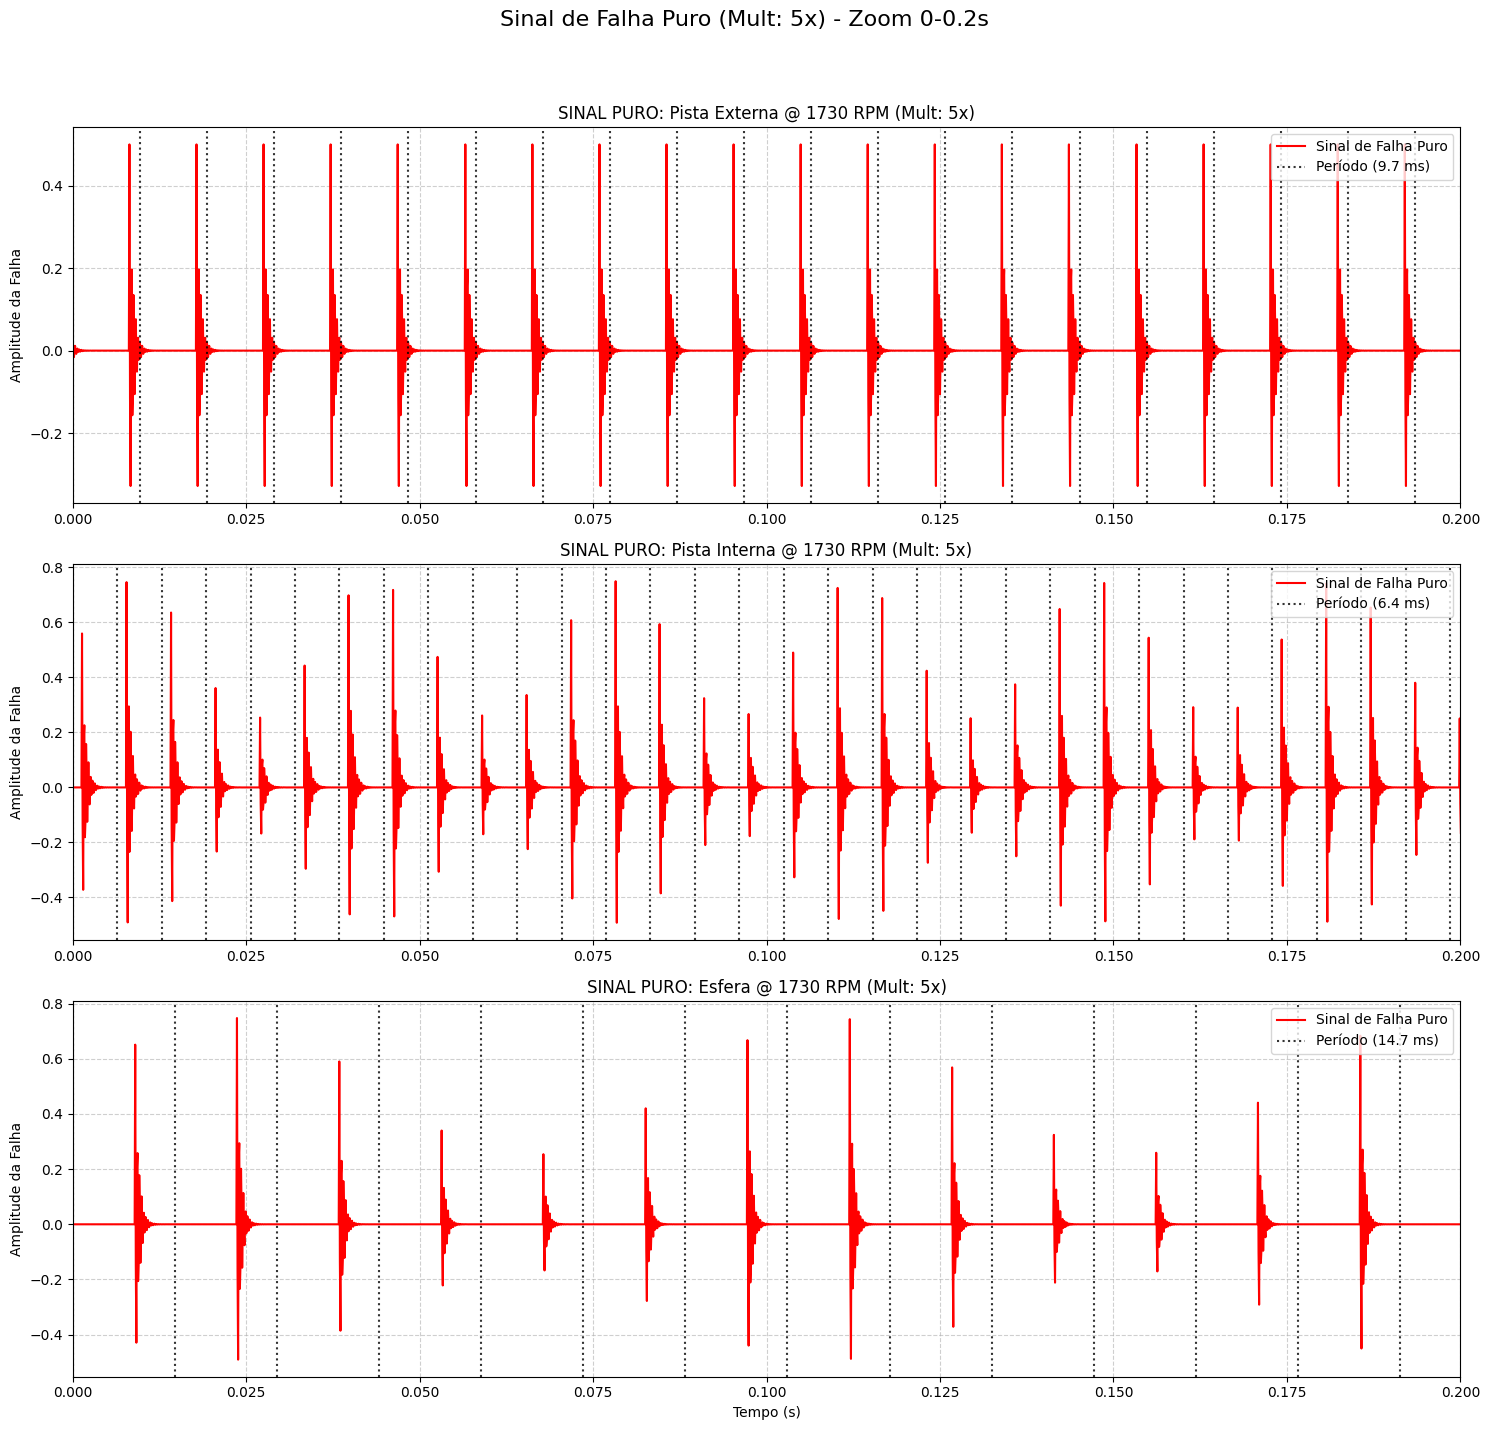

In [10]:
# =============================================================================
# BLOCO 2A: VERIFICAÇÃO DO SINAL DE FALHA PURO (DOMÍNIO DO TEMPO)
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np

print("--- PLOTANDO SINAL DE FALHA PURO (SINTÉTICO, ANTES DA SOMA) ---")

# --- 1. CONFIGURAÇÕES ---
classes_para_plotar = ['Pista Externa', 'Pista Interna', 'Esfera']
ZOOM_TIME_LIMIT_SEC = 0.2 # Zoom nos primeiros 200ms para ver a modulação
# Vamos pegar o multiplicador mais forte (100x) para ver o sinal de falha claramente
MULTIPLICADOR_ALVO = 5 

# Cria 3 subplots (um para cada falha)
fig, ax = plt.subplots(len(classes_para_plotar), 1, figsize=(15, 15))
fig.suptitle(f'Sinal de Falha Puro (Mult: {MULTIPLICADOR_ALVO}x) - Zoom 0-{ZOOM_TIME_LIMIT_SEC}s', fontsize=16)

# --- 2. LOOP POR CADA TIPO DE FALHA ---
try:
    for i, tipo_falha in enumerate(classes_para_plotar):
        
        ax_atual = ax[i]
        
        # --- 3. ENCONTRAR O SINAL SINTÉTICO (Combinado) ---
        # (Usa o df_sinais_treino que está em memória do Bloco 2)
        query_str = (f"tipo_falha_adicionada == '{tipo_falha}' and "
                     f"multiplicador_amplitude == {MULTIPLICADOR_ALVO}")
        query_sintetico = df_sinais_treino.query(query_str)
        
        if query_sintetico.empty:
            ax_atual.set_title(f"Sinal Sintético '{tipo_falha}' (Mult: {MULTIPLICADOR_ALVO}x) NÃO ENCONTRADO")
            continue
        
        amostra = query_sintetico.iloc[0]
        sinal_final_combinado = amostra['sinal_final']
        rpm_sint = amostra['rpm']
        chave_base_normal = amostra['base_normal']
        
        # --- 4. ENCONTRAR O SINAL NORMAL ORIGINAL (Base) ---
        # (Usa o dicionario_treino que está em memória do Bloco 1)
        if chave_base_normal not in dicionario_treino:
            ax_atual.set_title(f"Base Normal '{chave_base_normal}' NÃO ENCONTRADA NA MEMÓRIA")
            continue
        
        sinal_normal_base = dicionario_treino[chave_base_normal]['amplitude'].values
        
        # --- 5. SUBTRAIR A BASE PARA OBTER O SINAL "PURO" ---
        n_pontos = min(len(sinal_final_combinado), len(sinal_normal_base))
        sinal_falha_puro = sinal_final_combinado[:n_pontos] - sinal_normal_base[:n_pontos]
        
        # --- 6. CALCULAR TEMPO E PERÍODO ---
        t_sint = np.linspace(0, n_pontos / TAXA_AMOSTRAL, n_pontos, endpoint=False)
        
        fr_hz_sint = rpm_sint / 60
        # (A função 'calcular_frequencias_rolamento' DEVE estar em memória do Bloco 2)
        freqs_teoricas = calcular_frequencias_rolamento(fr=fr_hz_sint, **params_drive_end)
        freq_teorica_falha = freqs_teoricas[tipo_falha]
        periodo_falha_sec = 1.0 / freq_teorica_falha
        
        # --- 7. PLOTAR O SINAL DE FALHA PURO ---
        ax_atual.plot(t_sint, sinal_falha_puro, color='red', label='Sinal de Falha Puro')
        ax_atual.set_title(f"SINAL PURO: {tipo_falha} @ {rpm_sint} RPM (Mult: {MULTIPLICADOR_ALVO}x)")
        ax_atual.set_xlim(0, ZOOM_TIME_LIMIT_SEC)
        ax_atual.set_ylabel("Amplitude da Falha")
        ax_atual.grid(True, linestyle='--', alpha=0.6)
        
        # Adicionar marcadores de período de falha (quando o impacto ocorre)
        for t_impacto in np.arange(0, ZOOM_TIME_LIMIT_SEC, periodo_falha_sec):
            ax_atual.axvline(x=t_impacto, color='black', linestyle=':', alpha=0.8, 
                             label=f'Período ({periodo_falha_sec*1000:.1f} ms)' if t_impacto < 1e-6 else None)
        ax_atual.legend(loc='upper right')

    # Adicionar xlabel no último gráfico
    ax[len(classes_para_plotar)-1].set_xlabel('Tempo (s)')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except NameError as e:
    print(f"\nERRO DE EXECUÇÃO: {e}")
    print("Certifique-se de que o Bloco 1 (para 'dicionario_treino') e o Bloco 2 (para 'df_sinais_treino' e 'calcular_frequencias_rolamento')")
    print("foram executados nesta sessão antes de rodar este bloco de plotagem.")
except Exception as e:
    print(f"\nOcorreu um erro inesperado no plot: {e}")

## Plots FFT e time domain

--- COMPARAÇÃO NO DOMÍNIO DO TEMPO (Real vs. Novo Modelo Sintético) ---


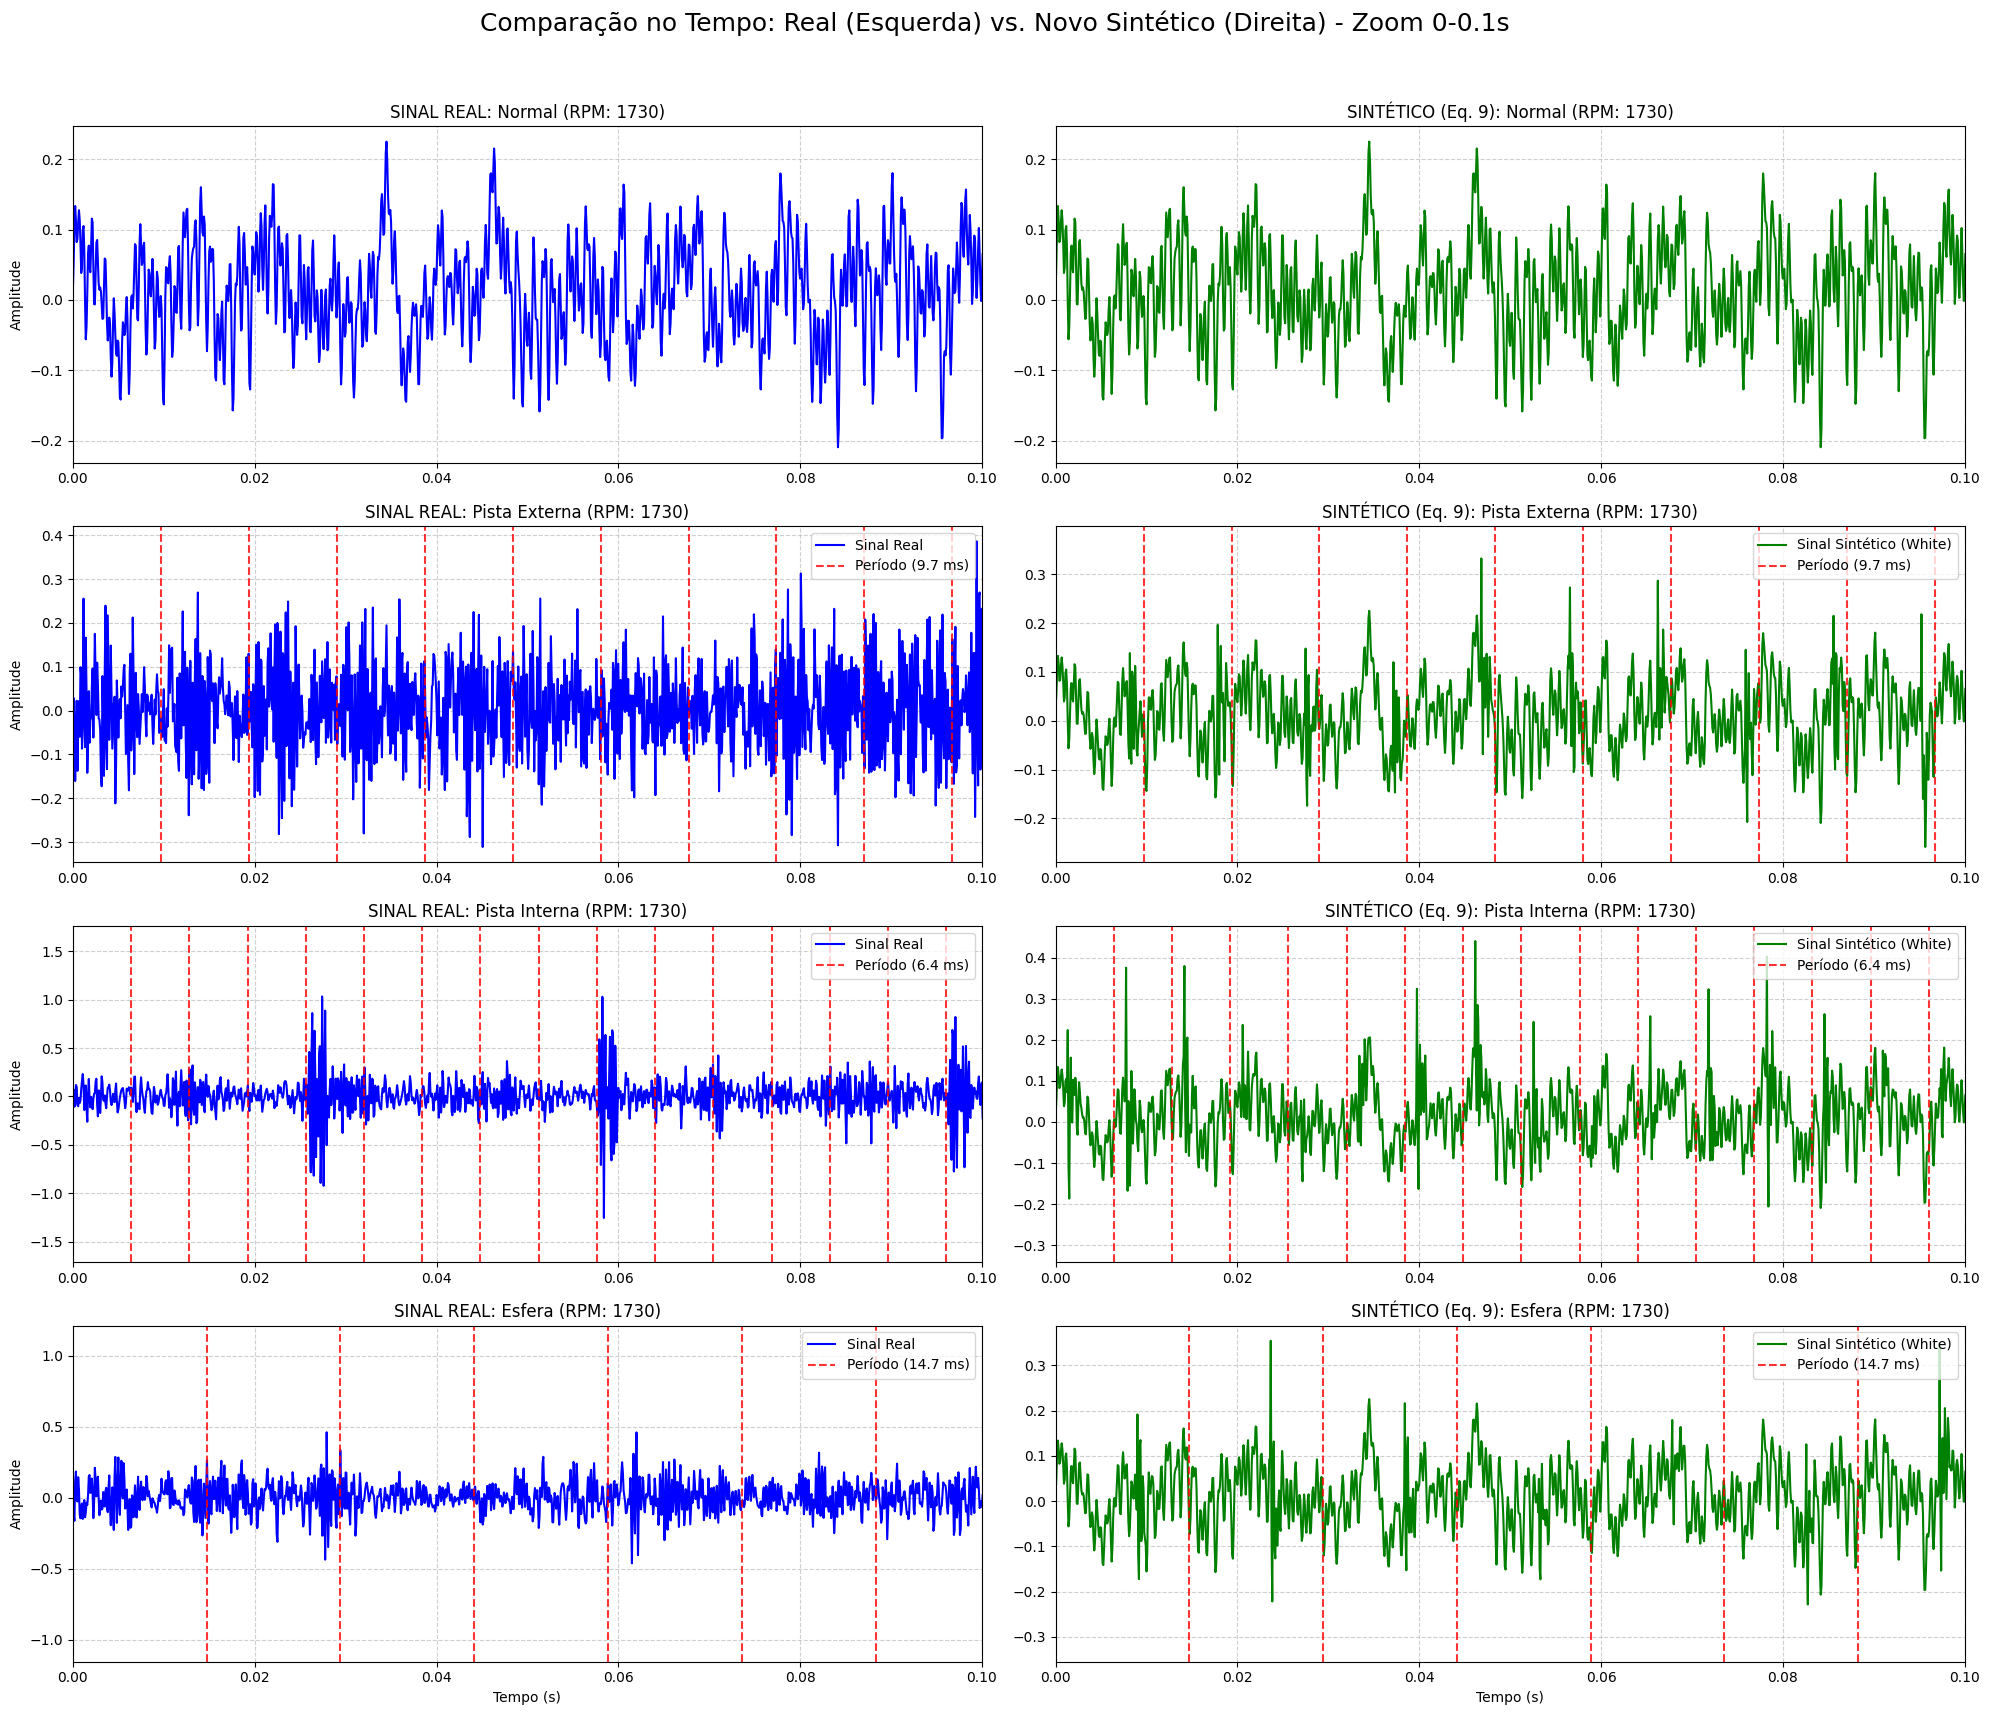

In [11]:
import matplotlib.pyplot as plt
import numpy as np

print("--- COMPARAÇÃO NO DOMÍNIO DO TEMPO (Real vs. Novo Modelo Sintético) ---")

# --- 1. CONFIGURAÇÕES ---
classes_para_plotar = ['Normal', 'Pista Externa', 'Pista Interna', 'Esfera']
ZOOM_TIME_LIMIT_SEC = 0.1 # Zoom nos primeiros 100ms para ver os pulsos

# Criar a grade de plots
fig, ax = plt.subplots(len(classes_para_plotar), 2, figsize=(20, 18))
fig.suptitle(f'Comparação no Tempo: Real (Esquerda) vs. Novo Sintético (Direita) - Zoom 0-{ZOOM_TIME_LIMIT_SEC}s', fontsize=18)

# --- 2. FUNÇÕES AUXILIARES (copiadas para a célula ser independente) ---
def encontrar_primeiro_segmento_real(tipo_falha):
    dicionario_fonte = dicionario_treino if tipo_falha == 'Normal' else dicionario_teste
    for df_seg in dicionario_fonte.values():
        if df_seg['tipo_falha'].iloc[0] == tipo_falha:
            return df_seg['amplitude'].values, df_seg['rotacao_rpm'].iloc[0]
    return None, None

def encontrar_primeiro_segmento_sintetico(tipo_falha):
    query_str = f"tipo_falha_adicionada == '{tipo_falha}'"
    query_sintetico = df_sinais_treino.query(query_str)
    if not query_sintetico.empty:
        amostra = query_sintetico.iloc[0]
        return amostra['sinal_final'], amostra['rpm']
    return None, None

# --- 3. LOOP DE PLOTAGEM ---
try:
    for i, tipo_falha in enumerate(classes_para_plotar):
        
        ax_real = ax[i, 0]
        ax_sint = ax[i, 1]

        # --- A. SINAL REAL (Esquerda) ---
        sinal_real, rpm_real = encontrar_primeiro_segmento_real(tipo_falha)
        freq_teorica = None
        
        if sinal_real is not None:
            N_real = len(sinal_real)
            t_real = np.linspace(0, N_real / TAXA_AMOSTRAL, N_real, endpoint=False)
            
            if tipo_falha != 'Normal':
                fr_hz_real = rpm_real / 60
                freq_teorica = calcular_frequencias_rolamento(fr=fr_hz_real, **params_drive_end)[tipo_falha]
                periodo_falha_sec = 1.0 / freq_teorica

            # Plot no tempo
            ax_real.plot(t_real, sinal_real, color='blue', label='Sinal Real')
            ax_real.set_title(f"SINAL REAL: {tipo_falha} (RPM: {rpm_real})")
            ax_real.set_xlim(0, ZOOM_TIME_LIMIT_SEC) # Aplica o Zoom
            ax_real.set_ylabel("Amplitude")
            ax_real.grid(True, linestyle='--', alpha=0.6)
            
            if freq_teorica:
                # Adiciona marcadores de período de falha
                for t_impacto in np.arange(periodo_falha_sec, ZOOM_TIME_LIMIT_SEC, periodo_falha_sec):
                    ax_real.axvline(x=t_impacto, color='red', linestyle='--', alpha=0.8, 
                                    label=f'Período ({periodo_falha_sec*1000:.1f} ms)' if t_impacto==periodo_falha_sec else None)
                ax_real.legend(loc='upper right')
        else:
            ax_real.set_title(f"SINAL REAL '{tipo_falha}' NÃO ENCONTRADO")

        # --- B. SINAL SINTÉTICO (Direita) ---
        sinal_sint, rpm_sint = encontrar_primeiro_segmento_sintetico(tipo_falha)
        
        if sinal_sint is not None:
            N_sint = len(sinal_sint)
            t_sint = np.linspace(0, N_sint / TAXA_AMOSTRAL, N_sint, endpoint=False)
            freq_teorica_sint = None
            
            if tipo_falha != 'Normal':
                fr_hz_sint = rpm_sint / 60
                freq_teorica_sint = calcular_frequencias_rolamento(fr=fr_hz_sint, **params_drive_end)[tipo_falha]
                periodo_falha_sec_sint = 1.0 / freq_teorica_sint

            # Plot no tempo
            ax_sint.plot(t_sint, sinal_sint, color='green', label='Sinal Sintético (White)')
            ax_sint.set_title(f"SINTÉTICO (Eq. 9): {tipo_falha} (RPM: {rpm_sint})")
            ax_sint.set_xlim(0, ZOOM_TIME_LIMIT_SEC) # Aplica o Zoom
            ax_sint.grid(True, linestyle='--', alpha=0.6)

            if freq_teorica_sint:
                # Adiciona marcadores de período de falha
                for t_impacto_sint in np.arange(periodo_falha_sec_sint, ZOOM_TIME_LIMIT_SEC, periodo_falha_sec_sint):
                    ax_sint.axvline(x=t_impacto_sint, color='red', linestyle='--', alpha=0.8, 
                                     label=f'Período ({periodo_falha_sec_sint*1000:.1f} ms)' if t_impacto_sint==periodo_falha_sec_sint else None)
                ax_sint.legend(loc='upper right')
        else:
            ax_sint.set_title(f"SINTÉTICO '{tipo_falha}' NÃO ENCONTRADO")

        # Adiciona xlabel apenas na última linha
        if i == len(classes_para_plotar) - 1:
            ax_real.set_xlabel('Tempo (s)')
            ax_sint.set_xlabel('Tempo (s)')

    fig.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

except NameError as e:
    print(f"\nERRO: Variável não encontrada ({e}).")
    print("Certifique-se de ter executado o Bloco 1 e o Bloco 2 (o novo) primeiro.")
except Exception as e:
    print(f"\nOcorreu um erro inesperado: {e}")


--- COMPARANDO FFT @ 1750 RPM (Sintético com Mult: 10x) ---


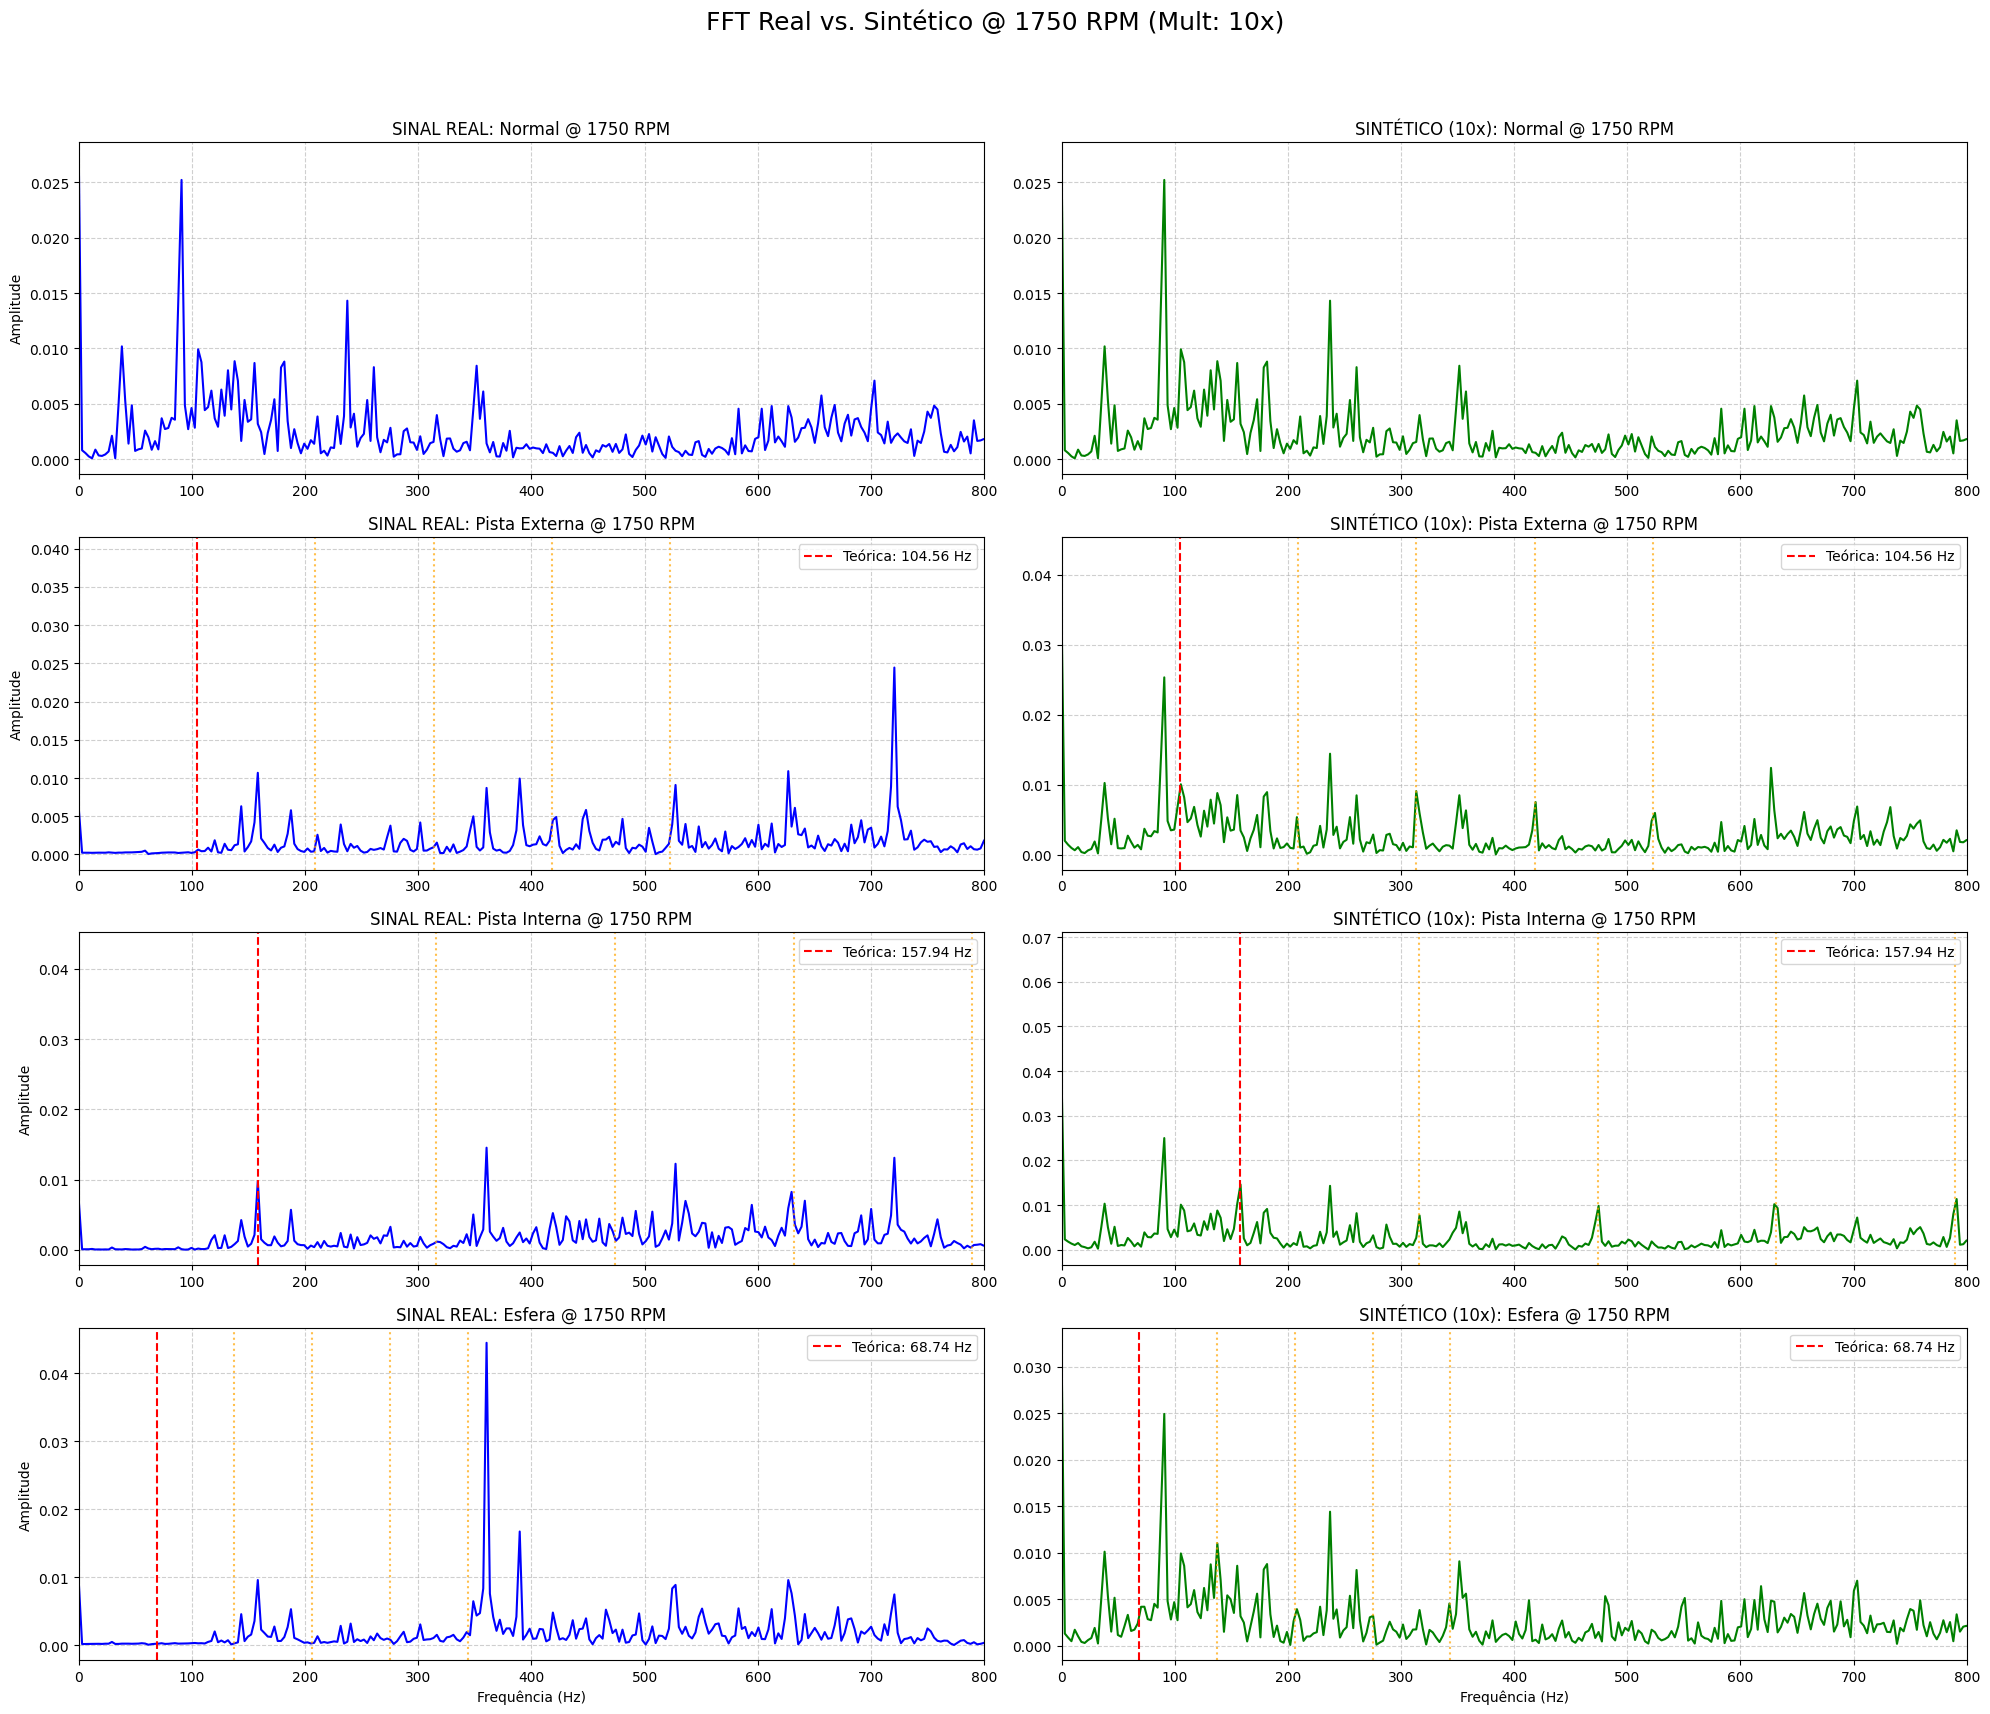

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. CONFIGURAÇÕES DO PLOT ---
# =====================================================================
# *** Mude aqui para o RPM que você quer inspecionar ***
RPM_PARA_PLOTAR = 1750  # Ex: 1730, 1750, 1773, ou 1797
# =====================================================================
MULTIPLICADOR_PARA_PLOTAR = 10 # Você pediu 10x

classes_para_plotar = ['Normal', 'Pista Externa', 'Pista Interna', 'Esfera']
XLIM_ZOOM = 800  # 0-800 Hz (Foco na freq. de falha e harmônicos)

print(f"--- COMPARANDO FFT @ {RPM_PARA_PLOTAR} RPM (Sintético com Mult: {MULTIPLICADOR_PARA_PLOTAR}x) ---")

# Cria a grade de plots
fig, ax = plt.subplots(len(classes_para_plotar), 2, figsize=(20, 18))
fig.suptitle(f'FFT Real vs. Sintético @ {RPM_PARA_PLOTAR} RPM (Mult: {MULTIPLICADOR_PARA_PLOTAR}x)', fontsize=18)

# --- 2. FUNÇÕES AUXILIARES DE BUSCA (Mais específicas) ---
def encontrar_segmento_real_especifico(tipo_falha, rpm_desejado):
    """Encontra o primeiro segmento REAL com um tipo de falha e RPM específicos."""
    dicionario_fonte = dicionario_treino if tipo_falha == 'Normal' else dicionario_teste
    
    for df_seg in dicionario_fonte.values():
        if (df_seg['tipo_falha'].iloc[0] == tipo_falha and 
            df_seg['rotacao_rpm'].iloc[0] == rpm_desejado):
            return df_seg['amplitude'].values, df_seg['rotacao_rpm'].iloc[0]
    return None, None # Não encontrou

def encontrar_segmento_sintetico_especifico(tipo_falha, rpm_desejado, multiplicador):
    """Encontra o primeiro segmento SINTÉTICO com filtros específicos."""
    if tipo_falha == 'Normal':
        # 'Normal' não tem multiplicador, busca só por RPM
        query_str = f"tipo_falha_adicionada == 'Normal' and rpm == {rpm_desejado}"
    else:
        # Falhas buscam por RPM e Multiplicador
        query_str = (f"tipo_falha_adicionada == '{tipo_falha}' and "
                     f"rpm == {rpm_desejado} and "
                     f"multiplicador_amplitude == {multiplicador}")
    
    query_sintetico = df_sinais_treino.query(query_str)
    if not query_sintetico.empty:
        amostra = query_sintetico.iloc[0]
        return amostra['sinal_final'], amostra['rpm']
    return None, None # Não encontrou

# --- 3. LOOP DE PLOTAGEM ---
try:
    for i, tipo_falha in enumerate(classes_para_plotar):
        
        ax_real = ax[i, 0]
        ax_sint = ax[i, 1]

        # --- A. SINAL REAL (Esquerda) ---
        sinal_real, rpm_real = encontrar_segmento_real_especifico(tipo_falha, RPM_PARA_PLOTAR)
        freq_teorica = None
        
        if sinal_real is not None:
            # Calcula FFT Real
            N_real = len(sinal_real)
            espectro_real = np.abs(np.fft.fft(sinal_real)[0:N_real//2]) / (N_real/2)
            freqs_real = np.fft.fftfreq(N_real, 1 / TAXA_AMOSTRAL)[:N_real//2]
            
            # Calcula Freq. Teórica (se não for 'Normal')
            if tipo_falha != 'Normal':
                fr_hz_real = rpm_real / 60
                freq_teorica = calcular_frequencias_rolamento(fr=fr_hz_real, **params_drive_end)[tipo_falha]

            # Plota Real (Zoom)
            ax_real.plot(freqs_real, espectro_real, color='blue')
            ax_real.set_title(f'SINAL REAL: {tipo_falha} @ {rpm_real} RPM')
            ax_real.set_ylabel('Amplitude')
            ax_real.set_xlim(0, XLIM_ZOOM)
            ax_real.grid(True, linestyle='--', alpha=0.6)
            
            if freq_teorica:
                ax_real.axvline(x=freq_teorica, color='red', linestyle='--', label=f'Teórica: {freq_teorica:.2f} Hz')
                for h in range(2, 6): ax_real.axvline(x=freq_teorica * h, color='orange', linestyle=':', alpha=0.7)
                ax_real.legend()
        else:
            ax_real.set_title(f"SINAL REAL '{tipo_falha}' @ {RPM_PARA_PLOTAR} RPM\nNÃO ENCONTRADO")

        # --- B. SINAL SINTÉTICO (Direita) ---
        sinal_sint, rpm_sint = encontrar_segmento_sintetico_especifico(tipo_falha, RPM_PARA_PLOTAR, MULTIPLICADOR_PARA_PLOTAR)
        
        if sinal_sint is not None:
            # Calcula FFT Sintético
            N_sint = len(sinal_sint)
            espectro_sint = np.abs(np.fft.fft(sinal_sint)[0:N_sint//2]) / (N_sint/2)
            freqs_sint = np.fft.fftfreq(N_sint, 1 / TAXA_AMOSTRAL)[:N_sint//2]

            # Plota Sintético (Zoom)
            ax_sint.plot(freqs_sint, espectro_sint, color='green')
            ax_sint.set_title(f'SINTÉTICO ({MULTIPLICADOR_PARA_PLOTAR}x): {tipo_falha} @ {rpm_sint} RPM')
            ax_sint.set_xlim(0, XLIM_ZOOM)
            ax_sint.grid(True, linestyle='--', alpha=0.6)
            
            if freq_teorica: # Usa a mesma freq teórica do real para consistência
                ax_sint.axvline(x=freq_teorica, color='red', linestyle='--', label=f'Teórica: {freq_teorica:.2f} Hz')
                for h in range(2, 6): ax_sint.axvline(x=freq_teorica * h, color='orange', linestyle=':', alpha=0.7)
                ax_sint.legend()
        else:
            ax_sint.set_title(f"SINTÉTICO ({MULTIPLICADOR_PARA_PLOTAR}x) '{tipo_falha}' @ {RPM_PARA_PLOTAR} RPM\nNÃO ENCONTRADO")

        # Adiciona xlabel apenas na última linha
        if i == len(classes_para_plotar) - 1:
            ax_real.set_xlabel('Frequência (Hz)')
            ax_sint.set_xlabel('Frequência (Hz)')

    fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajuste para o supertítulo
    plt.show()

except NameError as e:
    print(f"\nERRO: Variável não encontrada ({e}).")
    print("Certifique-se de ter executado o Bloco 1 e o Bloco 2 (com o novo modelo) primeiro.")
except Exception as e:
    print(f"\nOcorreu um erro inesperado: {e}")

--- ENCONTRANDO O PICO DE RESSONÂNCIA REAL ---

  PICO DE RESSONÂNCIA REAL ENCONTRADO!
  Frequência: 3278.32 Hz
  Amplitude: 0.0307

Instrução: Use '3278.32' como o novo valor para 'freq_natural_hz' no Bloco 2.


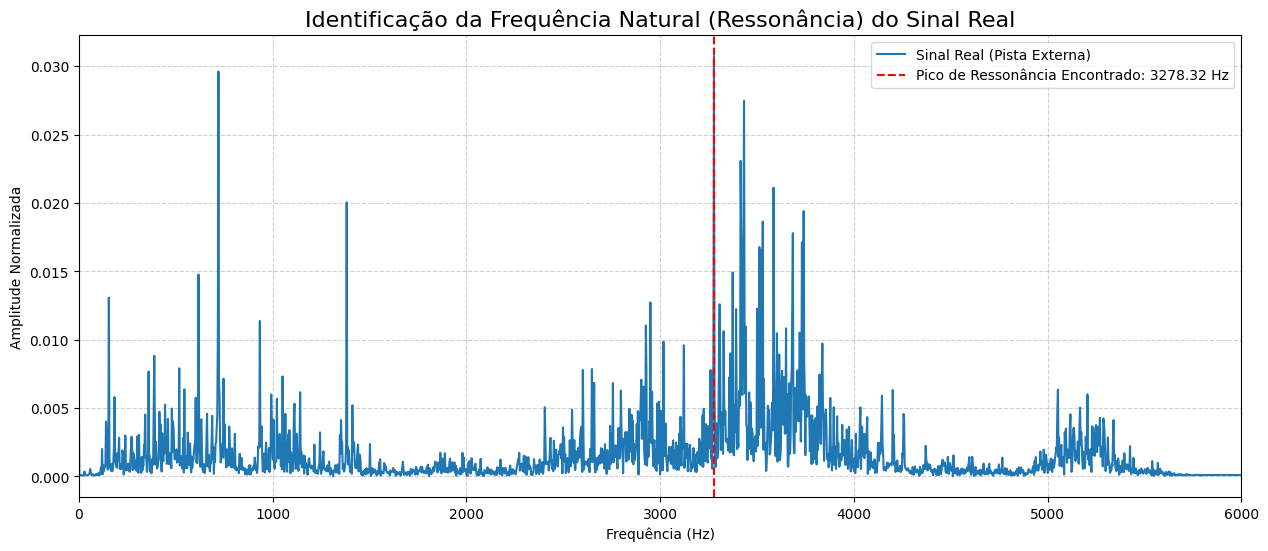

In [14]:
import matplotlib.pyplot as plt
import numpy as np

print("--- ENCONTRANDO O PICO DE RESSONÂNCIA REAL ---")

try:
    # --- 1. ESCOLHA UM SINAL DE FALHA REAL PARA MEDIR ---
    # (Vamos usar 'Pista Externa' como nosso medidor)
    sinal_real, rpm_real = None, None
    for df_seg in dicionario_teste.values():
        if df_seg['tipo_falha'].iloc[0] == 'Pista Externa':
            sinal_real = df_seg['amplitude'].values
            rpm_real = df_seg['rotacao_rpm'].iloc[0]
            break
            
    if sinal_real is None:
        raise Exception("Nenhum sinal real de 'Pista Externa' encontrado no dicionario_teste para medir.")

    # --- 2. CALCULAR O FFT REAL ---
    N_real = len(sinal_real)
    espectro_real = np.abs(np.fft.fft(sinal_real)[0:N_real//2]) / (N_real/2)
    freqs_real = np.fft.fftfreq(N_real, 1 / TAXA_AMOSTRAL)[:N_real//2]
    
    # --- 3. ENCONTRAR O PICO DE RESSONÂNCIA (O PONTO CRÍTICO) ---
    
    # Ignora as frequências de falha de baixa frequência (ex: < 1000 Hz)
    limite_baixa_freq_hz = 1000 
    
    # Cria uma máscara para focar apenas na região de ressonância
    mascara_alta_freq = freqs_real > limite_baixa_freq_hz
    
    # Encontra o índice do pico (amplitude máxima) *apenas* na região de alta frequência
    indice_pico_hf = np.argmax(espectro_real[mascara_alta_freq])
    
    # Converte esse índice de volta para um índice do array original
    indice_pico_global = np.where(mascara_alta_freq)[0][indice_pico_hf]
    
    # Obtém a frequência exata desse pico
    freq_pico_real = freqs_real[indice_pico_global]
    amplitude_pico_real = espectro_real[indice_pico_global]

    print("\n" + "="*50)
    print(f"  PICO DE RESSONÂNCIA REAL ENCONTRADO!")
    print(f"  Frequência: {freq_pico_real:.2f} Hz")
    print(f"  Amplitude: {amplitude_pico_real:.4f}")
    print("="*50 + "\n")
    print(f"Instrução: Use '{freq_pico_real:.2f}' como o novo valor para 'freq_natural_hz' no Bloco 2.")

    # --- 4. PLOTAR PARA VERIFICAÇÃO VISUAL ---
    plt.figure(figsize=(15, 6))
    plt.plot(freqs_real, espectro_real, label='Sinal Real (Pista Externa)')
    
    # Desenha a linha vertical no pico que encontramos
    plt.axvline(x=freq_pico_real, color='red', linestyle='--', 
                label=f'Pico de Ressonância Encontrado: {freq_pico_real:.2f} Hz')
    
    plt.title('Identificação da Frequência Natural (Ressonância) do Sinal Real', fontsize=16)
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Amplitude Normalizada')
    plt.xlim(0, TAXA_AMOSTRAL / 2) # Espectro completo
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

except NameError as e:
    print(f"\nERRO: Variável não encontrada ({e}). Certifique-se de que o Bloco 1 foi executado.")
except Exception as e:
    print(f"\nOcorreu um erro: {e}")

## Cálculo dos atributos

In [ ]:
# =============================================================================
# BLOCO 3: FUNÇÃO DE EXTRAÇÃO DE FEATURES
# =============================================================================
import pandas as pd

def extrair_features_pipeline(df_sinais_treino, dicionario_teste, TAXA_AMOSTRAL):
    """
    Executa o pipeline de extração de features nos dados de treino e teste.
    """
    
    print("\n--- Iniciando extração de atributos do conjunto de TREINO ---")
    lista_de_features_treino = []
    # (Assume que 'extrair_todas_features' foi definida na célula de Funções Auxiliares)
    for linha in df_sinais_treino.itertuples():
        features = extrair_todas_features(linha.sinal_final, TAXA_AMOSTRAL)
        features['tipo_falha_adicionada'] = linha.tipo_falha_adicionada
        features['rpm'] = linha.rpm
        features['multiplicador_amplitude'] = linha.multiplicador_amplitude
        features['fase_adicionada_rad'] = linha.fase_adicionada_rad
        features['base_normal'] = linha.base_normal
        lista_de_features_treino.append(features)

    df_treino = pd.DataFrame(lista_de_features_treino)
    print(f"Extração de Treino concluída! {len(df_treino)} amostras.")

    # =============================================================================
    # --- PROCESSAMENTO DO CONJUNTO DE TESTE ---
    # =============================================================================
    print("\n--- Iniciando extração de atributos do conjunto de TESTE ---")
    lista_de_features_teste = []
    for chave, df_segmento in dicionario_teste.items():
        sinal = df_segmento['amplitude'].values
        features = extrair_todas_features(sinal, TAXA_AMOSTRAL)
        features['tipo_falha_adicionada'] = df_segmento['tipo_falha'].iloc[0]
        features['rpm'] = df_segmento['rotacao_rpm'].iloc[0]
        features['arquivo_origem'] = df_segmento['arquivo_origem'].iloc[0]
        lista_de_features_teste.append(features)

    df_teste = pd.DataFrame(lista_de_features_teste)
    print(f"Extração de Teste concluída! {len(df_teste)} amostras.")
    
    return df_treino, df_teste

print("Função 'extrair_features_pipeline' definida.")

--- Iniciando extração de atributos do conjunto de TREINO ---
Extração concluída! 17390 amostras no df_treino.

--- Iniciando extração de atributos do conjunto de TESTE ---
Extração concluída! 2897 amostras no df_teste.


--- AMOSTRA DO df_treino (DADOS TRATADOS PARA TREINAMENTO) ---
    TF2_std   TF3_rms  TF4_fator_forma  FF2_freq_central  FF3_rms_freq  \
0  0.070003  0.071239         1.266737       1705.195192   2274.701036   
1  0.069856  0.071094         1.261392       1706.235559   2278.259140   
2  0.069692  0.070933         1.261013       1707.604441   2278.588253   
3  0.069963  0.071199         1.261307       1705.362608   2276.421048   
4  0.089851  0.090989         1.430602       2257.752506   2788.311502   

   FF5_assimetria_espectral  FF_pico_50_200Hz tipo_falha_adicionada   rpm  \
0                  0.916930         90.820312         Pista Externa  1730   
1                  0.914737         90.820312         Pista Externa  1730   
2                  0.915977         90.

In [15]:
# =============================================================================
# BLOCO 4: SALVAR OS DATAFRAMES FINAIS EM CSV (COM CAMINHO ESPECÍFICO)
# =============================================================================

import os

# Caminho de saída EXATO fornecido por você
caminho_base_output = r'C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset\TCC'

# Cria o diretório se ele não existir
if not os.path.exists(caminho_base_output):
    os.makedirs(caminho_base_output)
    print(f"Diretório criado em: {caminho_base_output}")

# Define os nomes dos arquivos
caminho_csv_treino = os.path.join(caminho_base_output, 'df_treino_features.csv')
caminho_csv_teste = os.path.join(caminho_base_output, 'df_teste_features.csv')

try:
    # Salva o DataFrame de treino
    df_treino.to_csv(caminho_csv_treino, index=False)
    print(f"\nDataFrame de TREINO (features) salvo com sucesso em:")
    print(f"{caminho_csv_treino}")

    # Salva o DataFrame de teste
    df_teste.to_csv(caminho_csv_teste, index=False)
    print(f"\nDataFrame de TESTE (features) salvo com sucesso em:")
    print(f"{caminho_csv_teste}")

except NameError:
    print("\nERRO: Os DataFrames 'df_treino' ou 'df_teste' não foram encontrados.")
    print("Certifique-se de que o Bloco 3 foi executado com sucesso antes de salvar.")
except Exception as e:
    print(f"\nOcorreu um erro inesperado ao salvar os arquivos: {e}")


DataFrame de TREINO (features) salvo com sucesso em:
C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset\TCC\df_treino_features.csv

DataFrame de TESTE (features) salvo com sucesso em:
C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset\TCC\df_teste_features.csv
